### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [77]:
import numpy as np
from scipy import stats
import scipy.special as sp
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from matplotlib import pyplot as plt
import corner.corner as corner
import emcee
import acor
import dynesty
import ultranest
from ultranest.plot import cornerplot

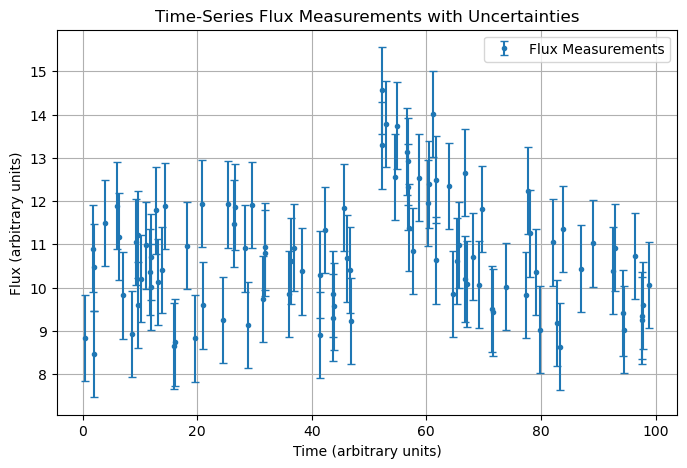

In [98]:
'''

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements.
It could be flux measurements from a star or some other transient. The first column is time (arbitrary units),
the second column is the flux (arbitrary units), and the third column are homoescedastic measurement
uncertainties on the flux. Plot this data with the uncertainties.

'''

data = np.load("hw_data/hw5_data_1.npy")
t = data[:, 0]  # Time
flux = data[:, 1]  # Flux
varFlux = data[:, 2]  


plt.figure(figsize=(8, 5))
plt.errorbar(t, flux, yerr=varFlux, fmt='o', markersize=3, capsize=3, label="Flux Measurements")
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Flux (arbitrary units)")
plt.title("Time-Series Flux Measurements with Uncertainties")
plt.legend()
plt.grid(True)
plt.show()





SRT: Looks good!

In [130]:
'''
2) Code this burst model, and code a likelihood function for this data with the burst model. Hint: This is 
similar in spirit to the likelihood when fitting polynomials to data, except now  is time, and the polynomial
model is now the burst model.

'''
# Define the burst model
def burst_model(t, b, A, t0, alpha):
    return b + A * np.exp(-((t - t0) ** 2) / (2 * np.exp(alpha) ** 2))

# Log-prior function
def log_prior(params):
    b, A, t0, log_alpha = params
    if (0 <= b <= 50) and (0 <= A <= 50) and (0 <= t0 <= 100) and (-5 <= log_alpha <= 5):
        return 0  # log(1) for uniform prior
    return -np.inf  # log(0), invalid region


# Log-likelihood function
def log_likelihood(params, t, flux, varFlux):
    model_flux = burst_model(t, *params)
    chi2 = np.sum(((flux - model_flux) / varFlux) ** 2)
    return -0.5 * chi2  # Gaussian likelihood

# Log-posterior function (prior + likelihood)
def log_posterior(params, data):
    lp = log_prior(params)
    if np.isfinite(lp):
        return lp + log_likelihood(params, t, flux, varFlux)
    return -np.inf

SRT: You coded the wrong model here, Ayanah. This is more like the Gaussian model used in part 7. This will have an impact on all your downstream analyses. More care needed in reading the question. -4 points

In [201]:
'''
3:
Using one of the MCMC codes that we looked at in class (emcee, pymc3, PTMCMCSampler) perform a Bayesian 
analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of . 
You must decide on how many samples are appropriate for running your MCMC. For your priors, make them , , , and .

'''
ndim = 4  # number of parameters in the model
nwalkers = 15  # number of MCMC walkers
burn = 0  # "burn-in" period to let chains stabilize
nsteps = 20000 

np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim)) #* np.array([10.0, 5.0, 50, 0.1])  # Make sure parameters are within reasonable ranges


# the function call where all the work happens: 
sampler_emcee = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, flux, varFlux))
sampler_emcee.run_mcmc(starting_guesses, nsteps, progress=True)

# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler_emcee.chain[:, burn:, :].reshape(-1, ndim)

100%|███████████████████████████████████| 20000/20000 [00:04<00:00, 4612.31it/s]


(15, 20000, 4)
(300000, 4)
Taking every n = 5258 samples based on autocorrelation length.
Burning first n = 1000 samples.


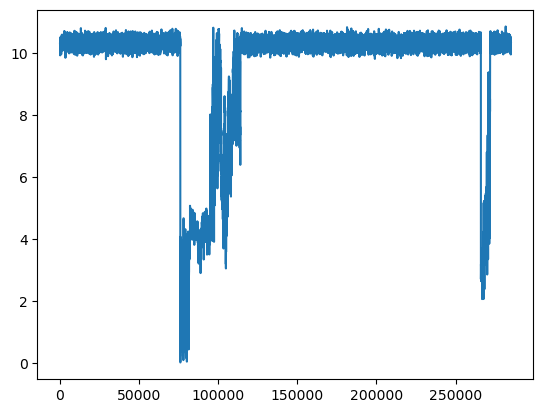

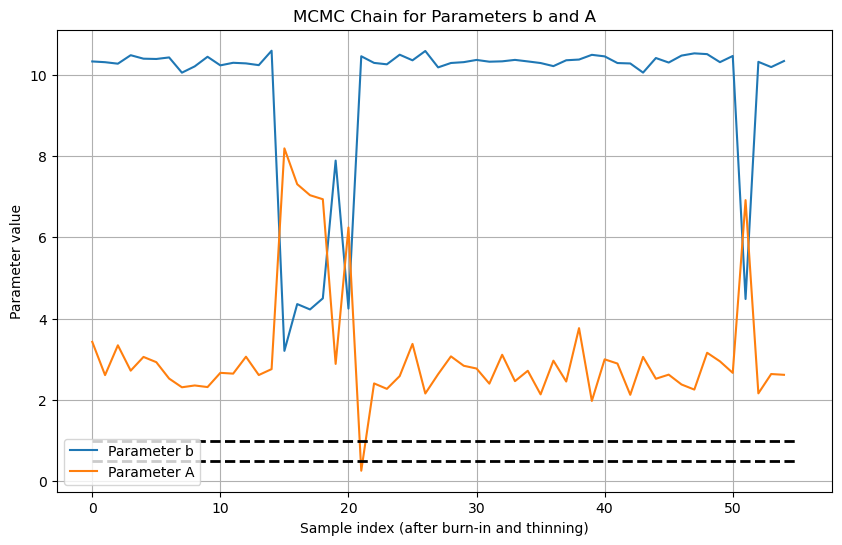

In [221]:
'''
4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation
length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

'''

burn = 1000  # Specify burn-in period (already discarded in previous steps)
emcee_trace_burned = sampler_emcee.chain[:, burn:, :].reshape(-1, ndim)  # WRONG LINE :: Get ride of caterpillar legs 
print(sampler_emcee.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain
c=emcee_trace_burned[:,0]
arraySize=np.size(c)
x=np.linspace(1,arraySize,arraySize) #worked with students on this section
plt.plot(x,c)


# Calculate autocorrelation length for thinning
thin = int(acor.acor(emcee_trace_burned[:, 0])[0])  # Thinning based on the first parameter
print(f'Taking every n = {thin} samples based on autocorrelation length.')
print(f'Burning first n = {burn} samples.')

# Plotting the chains of the first two parameters after burn-in and thinning
plt.figure(figsize=(10, 6))
plt.plot(emcee_trace_burned[::thin, 0], label='Parameter b')
plt.plot(emcee_trace_burned[::thin, 1], label='Parameter A')
plt.xlabel("Sample index (after burn-in and thinning)")
plt.ylabel("Parameter value")
plt.legend()
plt.title("MCMC Chain for Parameters b and A")
plt.grid(True)

# Injected values (for comparison)
plt.hlines(1.0, 0, len(emcee_trace_burned[::thin, 0]), color='k', lw=2, ls='dashed')
plt.hlines(0.5, 0, len(emcee_trace_burned[::thin, 0]), color='k', lw=2, ls='dashed')

plt.show()

SRT: It's clear here that something has gone wrong with one of the walkers in this emcee chain. It should look steady adn like a fuzzy catterpillar after the burn-in period. More commentary of this effect and several more diagnostic checks would have been needed, along with excising the probletmatic walker(s). -3 points

<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_18574/1861708310.py:1: SyntaxWarning: invalid escape sequence '\%'
  '''


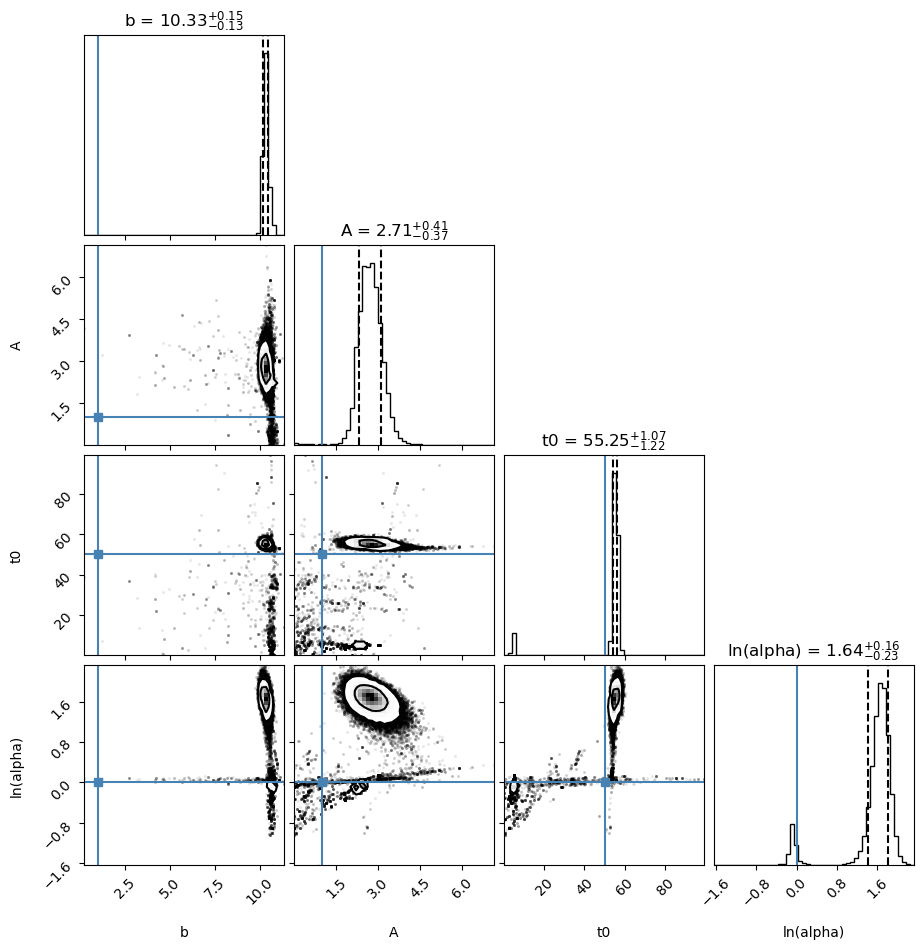

In [159]:
'''
5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.
'''
import corner
corner.corner(emcee_trace, labels=["b", "A", "t0", "ln(alpha)"],
                    truths=[1, 1, 50, 0],  # You can modify this if you have the true values
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    quantiles=[0.16, 0.84],  # 68% credible interval
                    levels=[0.68, 0.95],     # 68% and 95% credible intervals
                    bins=50,
                    title_quantiles=[0.16, 0.5, 0.84])  # This provides the quantiles for the titles

# Show the plot
plt.show()

SRT: Actually fairly good, and is only contaminated by the bad walkers.

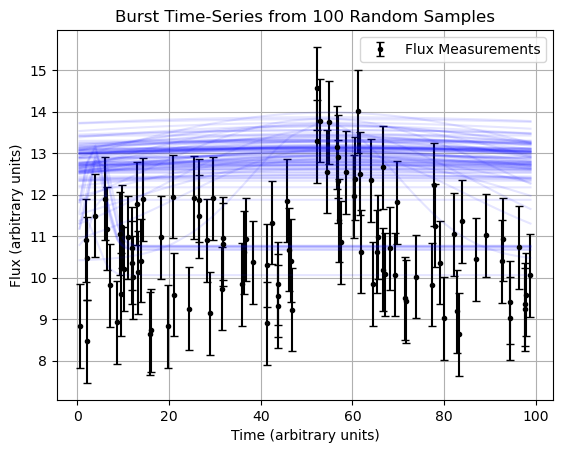

In [161]:
'''
6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst
time-series on a figure along with the original data. You may want to choose a transparency for these $100$ 
same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread 
of model solutions that are consistent with the data.
'''
random_samples = np.random.choice(emcee_trace.shape[0], 100, replace=False)

# Plot the original data
plt.errorbar(t, flux, yerr=varFlux, fmt='o', markersize=3, capsize=3, label="Flux Measurements", color='black')

# Plot the burst model for each random sample
for idx in random_samples:
    b, A, t0, log_alpha = emcee_trace[idx]
    model_flux = burst_model(t, b, A, t0, np.exp(log_alpha))  # Compute model flux
    plt.plot(t, model_flux, color='blue', alpha=0.1)  # Transparent curves

# Labels and display
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Flux (arbitrary units)")
plt.title("Burst Time-Series from 100 Random Samples")
plt.legend()
plt.grid(True)

#NOTE: I am running a bit low on time but if I did ghave the time I would try to work out how to 
#fix my lines

SRT: You've got the right idea here. But you already exponentiate log alpha in your burst model, so this did it twice. -1 point

In [255]:
'''
7)Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the 
nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model,
and for the original burst model. Compute the Bayes factor, and state which model is the favored description
of the data
'''

import dynesty
def my_likelihood(params):
    b, amplitude, sig, t_0 = params

    # compute intensity at every x position according to the model
    y_model = b + amplitude * np.exp((-(t-t_0)**2) / (2*sig**2))
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - flux)/varFlux)**2).sum()
    return like

param_names=["b", "A", "t0", "ln(alpha)"]

def my_prior_transform(cube):
    params = cube.copy()

    # transform b parameter: uniform prior
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform amplitude parameter: uniform prior
    lo = 0
    hi = 50
    params[1] = cube[1] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = np.exp(-2)
    hi = np.exp(2)
    params[2] = np.exp(cube[2] * (np.log(hi) - np.log(lo)) + np.log(lo))


     # transform t_0 parameter: uniform prior
    lo = 0
    hi = 100
    params[3] = cube[3] * (hi - lo) + lo
    return params

In [257]:
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)

In [259]:
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-52.5582..-52.5582]*| it/evals=7960/57963 eff=13.8283% N=400        0 
[ultranest] Likelihood function evaluations: 58008
[ultranest]   logZ = -67.82 +- 0.1715
[ultranest] Effective samples strategy satisfied (ESS = 2136.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.

logZ = -67.859 +- 0.474
  single instance: logZ = -67.859 +- 0.183
  bootstrapped   : logZ = -67.821 +- 0.474
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.77  │ ▁▁▁▁▁▁▁▁▁▁▂▃▃▅▅▇▇▇▇▇▇▅▄▄▃▂▁▁▁▁▁▁   ▁▁ │10.88     10.31 +- 0.12
    A                   : 1.31  │ ▁ ▁▁▁▁▁▂▃▃▅▆▇▇▇▆▇▆▅▄▂▂▂▁▁▁▁▁▁▁ ▁   ▁▁ │4.95      2.78 +- 0.38
    t0                  : 1.54

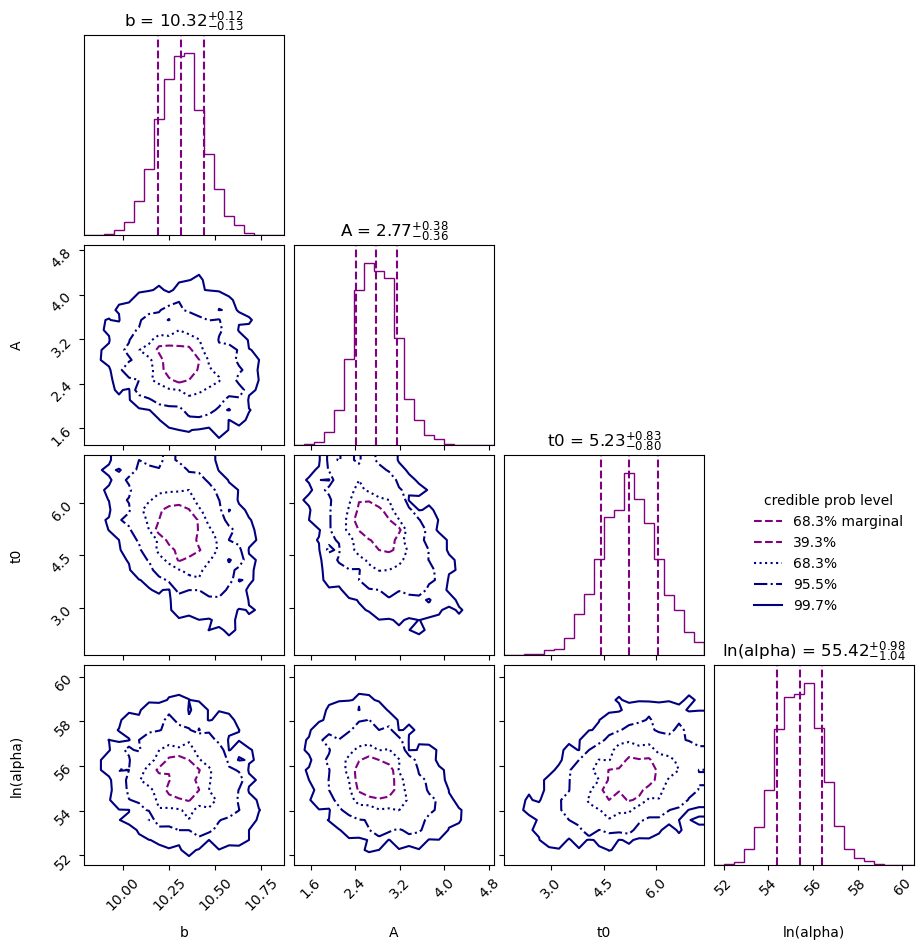

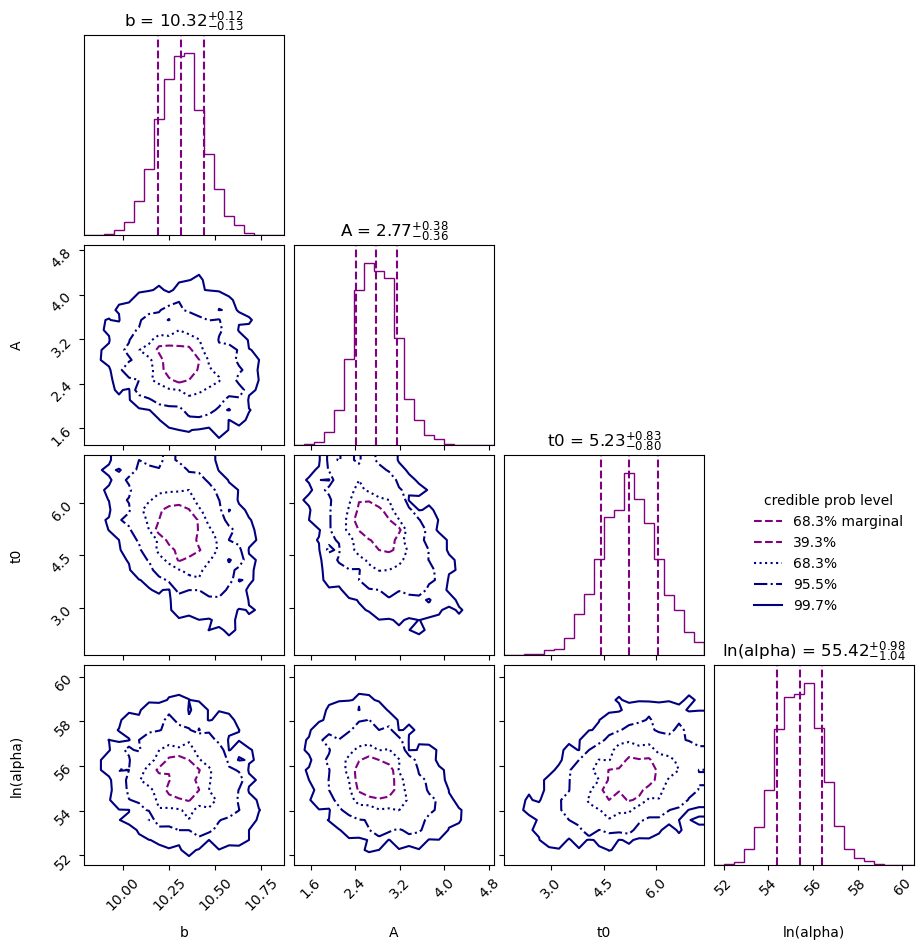

In [261]:
from ultranest.plot import cornerplot
cornerplot(result)

SRT: Parameter labeling is in the wrong order. -1 point

SRT: Given that this part was about Bayes factors between models, I expected some commentary on the fact that you realized you coded the wrong model up top, since the Gaussian model is introduced here. No nested sampling of the original intended burst model here, and no Bayes factors. -4 points

SRT: Overall, this was well attempted, Ayanah. I think with the correction of the original modeling mistake in the first parts, this would have been very close all correct. But more care and time reading and working on the problems is needed. 

38/50